# Feature selection with variance

In [1]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, rankdata
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE

## read in data

In [2]:
# read in file
df = pd.read_csv("Brain_GSE50161.csv")

In [3]:
df

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,834,ependymoma,12.498150,7.604868,6.880934,9.027128,4.176175,7.224920,6.085942,6.835999,...,9.979005,9.926470,12.719785,12.777792,5.403657,4.870548,4.047380,3.721936,4.516434,4.749940
1,835,ependymoma,13.067436,7.998090,7.209076,9.723322,4.826126,7.539381,6.250962,8.012549,...,11.924749,11.215930,13.605662,13.401342,5.224555,4.895315,3.786437,3.564481,4.430891,4.491416
2,836,ependymoma,13.068179,8.573674,8.647684,9.613002,4.396581,7.813101,6.007746,7.178156,...,12.154405,11.532460,13.764593,13.477800,5.303565,5.052184,4.005343,3.595382,4.563494,4.668827
3,837,ependymoma,12.456040,9.098977,6.628784,8.517677,4.154847,8.361843,6.596064,6.347285,...,11.969072,11.288801,13.600828,13.379029,4.953429,4.708371,3.892318,3.759429,4.748381,4.521275
4,838,ependymoma,12.699958,8.800721,11.556188,9.166309,4.165891,7.923826,6.212754,6.866387,...,11.411701,11.169317,13.751442,13.803646,4.892677,4.773806,3.796856,3.577544,4.504385,4.541450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,959,pilocytic_astrocytoma,12.658228,8.843270,7.672655,9.125912,5.495477,8.603892,7.747514,5.828978,...,13.170441,12.676080,14.124837,13.996436,4.913579,4.399176,3.878855,3.680103,4.726784,4.564637
126,960,pilocytic_astrocytoma,12.812823,8.510550,8.729699,9.104402,3.967228,7.719089,7.092496,6.504812,...,13.040267,12.403316,13.978009,13.812916,5.189600,4.912618,3.764800,3.664920,4.628355,4.761351
127,961,pilocytic_astrocytoma,12.706991,8.795721,7.772359,8.327273,6.329383,8.550471,6.613332,6.308945,...,12.825383,12.439265,14.328373,14.008693,4.931460,4.712895,3.913637,3.700964,4.764693,4.834952
128,962,pilocytic_astrocytoma,12.684593,8.293938,7.228186,8.494428,6.049414,8.214729,7.287758,5.732710,...,13.116581,12.657967,14.390346,14.194904,4.871092,4.739400,3.782980,3.920363,4.665584,4.613326


In [4]:
#Count the number of samples of five subtypes.
sns.set(rc={'figure.figsize':(10,7)})
cell_type = ['ependymoma', 'glioblastoma',' medulloblastoma', 'pilocytic_astrocytoma','normal']
sns.set(font_scale = 1.3)
def count_plot(label, title):
    ax = sns.countplot(x=label)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    
    plt.title(title)
    plt.show()

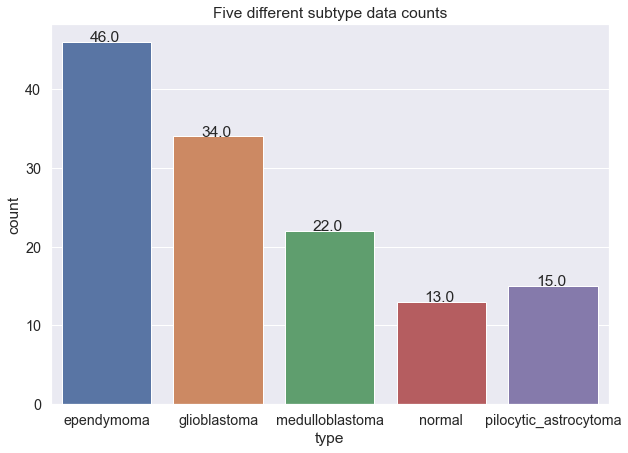

In [5]:
subtype_counts = count_plot(df["type"], "Five different subtype data counts")
subtype_counts

In [6]:
# first column is the samples
# second column is the types for brain cancers.
print(df['type'].value_counts())
# replace type to numbers
df['type'] = df['type'].replace(['ependymoma', 'glioblastoma','medulloblastoma', 'pilocytic_astrocytoma','normal'],[0,1,2,3,4])

ependymoma               46
glioblastoma             34
medulloblastoma          22
pilocytic_astrocytoma    15
normal                   13
Name: type, dtype: int64


## Filter Methods

In [7]:
# Use ANOVA to filter genes based on p-value

stat_ANOVA = []

# loop through each gene 
# to get gene expression values for a certain gene for each subtype
# to get all gene expression values for each subtype (whole loop)
for g in range(2, df.shape[1]):
    
    # subset type 0 (ependymoma) for gene g
    # .iloc[:,g] means all rows and column g
    type0 = np.array(df[df.type == 0].iloc[:,g])
    
    # subset type 1 (glioblastoma) for gene g
    type1 = np.array(df[df.type == 1].iloc[:,g])
    
    # subset type 2 (medulloblastoma) for gene g
    type2 = np.array(df[df.type == 2].iloc[:,g])
    
    # subset type 3 (pilocytic_astrocytoma) for gene g
    type3 = np.array(df[df.type == 3].iloc[:,g])
    
    # subset type 4 (normal) for gene g
    type4 = np.array(df[df.type == 4].iloc[:,g])
    
    # run 1-way between subjects ANOVA
    # Returns: The computed F statistic of the test; The associated p-value from the F distribution.
    result = f_oneway(type0, type1, type2, type3, type4)
    
    # append p-value
    stat_ANOVA.append(result[1])
        
    if g%1000 == 0:
        print(g)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000


In [8]:
# if the p value of the specific gene (between all subtypes) is less than 0.0001 then return the gene
# first two colunms are sample and type
stat_TF = [True, True]

for i in stat_ANOVA:
    if i <= 0.0001:
        stat_TF.append(True)
    else:
        stat_TF.append(False)

In [9]:
# stat_TF has the corresponding order with genes
# if stat_TF = True, get the column through .loc
df_ANOVA = df.loc[:,stat_TF]
df_ANOVA

,samples,type,1007_s_at,1053_at,117_at,1255_g_at,1294_at,1431_at,1438_at,1487_at,...,91920_at,AFFX-HSAC07/X00351_3_at,AFFX-HSAC07/X00351_5_at,AFFX-HSAC07/X00351_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-PheX-M_at,AFFX-r2-Bs-phe-M_at
0,834,0,12.498150,7.604868,6.880934,4.176175,7.224920,5.513410,7.541986,7.905140,...,10.956206,13.087353,12.786701,13.104597,13.027510,13.092592,9.104209,7.452986,3.882678,4.483687
1,835,0,13.067436,7.998090,7.209076,4.826126,7.539381,6.173106,8.317030,8.269136,...,10.255266,13.912946,13.532344,13.814658,14.237459,14.229670,10.411498,9.122687,3.744942,3.673009
2,836,0,13.068179,8.573674,8.647684,4.396581,7.813101,6.323471,7.661874,8.327897,...,10.364209,14.378190,13.937428,14.248673,14.402930,14.447217,11.321259,9.822739,3.813011,3.541582
3,837,0,12.456040,9.098977,6.628784,4.154847,8.361843,6.008684,7.663790,7.730238,...,8.451971,13.755865,13.383430,13.660059,13.369370,13.457756,9.924395,8.028984,3.820466,3.593411
4,838,0,12.699958,8.800721,11.556188,4.165891,7.923826,5.279579,9.521956,7.581397,...,10.490535,14.077636,13.760155,14.042310,13.835195,14.029920,10.786574,9.086955,3.865816,4.355079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,959,3,12.658228,8.843270,7.672655,5.495477,8.603892,4.967369,7.014209,8.666578,...,8.719159,13.967509,13.242701,13.713351,13.663155,13.609845,10.719271,8.359550,3.906140,3.892008
126,960,3,12.812823,8.510550,8.729699,3.967228,7.719089,5.082896,7.981177,8.737005,...,9.022079,13.896949,13.232039,13.696252,14.382744,14.382647,10.303234,8.257289,4.002341,4.069697
127,961,3,12.706991,8.795721,7.772359,6.329383,8.550471,4.919414,6.638493,8.724114,...,9.545324,13.823257,12.218713,13.097621,13.699895,13.556569,11.074307,8.822692,3.904377,3.685399
128,962,3,12.684593,8.293938,7.228186,6.049414,8.214729,5.140635,7.225376,8.333919,...,10.455301,13.935221,13.133453,13.494138,13.499406,13.422512,10.848698,8.689571,3.809154,3.683920


In [10]:
# Use variance to filter
stat_var = []

# loop through each genes
for g in range(2, df_ANOVA.shape[1]):
    stat_var.append(statistics.variance(df_ANOVA.iloc[:,g]))
    if g % 1000 == 0:
        print(g)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [11]:
np.median(stat_var)

0.5088812901520702

In [12]:
var_TF = [True, True]
for i in stat_var:
    if i >= 0.5:
        var_TF.append(True)
    else:
        var_TF.append(False)

In [13]:
df_var = df_ANOVA.loc[:,var_TF]
df_var

,samples,type,1007_s_at,117_at,1255_g_at,1438_at,1552256_a_at,1552269_at,1552274_at,1552275_s_at,...,65588_at,823_at,87100_at,89977_at,90265_at,91816_f_at,91920_at,AFFX-HSAC07/X00351_5_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_MB_at
0,834,0,12.498150,6.880934,4.176175,7.541986,8.386617,8.222273,6.522746,7.031419,...,8.227121,7.232380,7.193072,7.166401,8.178087,7.762491,10.956206,12.786701,9.104209,7.452986
1,835,0,13.067436,7.209076,4.826126,8.317030,9.208559,6.914568,7.805840,7.953560,...,9.021009,9.822285,8.391833,6.422113,10.667338,11.170625,10.255266,13.532344,10.411498,9.122687
2,836,0,13.068179,8.647684,4.396581,7.661874,9.344553,6.706525,7.702766,7.713712,...,8.395228,12.257851,8.582821,6.786965,9.574368,8.443621,10.364209,13.937428,11.321259,9.822739
3,837,0,12.456040,6.628784,4.154847,7.663790,8.996408,8.985858,7.073578,7.603237,...,9.058105,8.526016,6.461401,6.104773,8.743637,9.597551,8.451971,13.383430,9.924395,8.028984
4,838,0,12.699958,11.556188,4.165891,9.521956,10.040652,8.221752,7.916434,8.139826,...,8.123893,9.156358,7.462321,7.626676,8.123024,8.106023,10.490535,13.760155,10.786574,9.086955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,959,3,12.658228,7.672655,5.495477,7.014209,10.233177,4.996330,7.350546,7.826477,...,8.665639,10.151682,8.639360,6.926578,8.559671,9.353849,8.719159,13.242701,10.719271,8.359550
126,960,3,12.812823,8.729699,3.967228,7.981177,9.902292,5.379189,8.527913,8.150819,...,9.805503,10.226974,7.584308,6.476481,8.753927,9.382903,9.022079,13.232039,10.303234,8.257289
127,961,3,12.706991,7.772359,6.329383,6.638493,9.638112,4.627095,7.797212,8.870719,...,8.518508,9.964082,8.383192,7.098009,8.466273,8.744321,9.545324,12.218713,11.074307,8.822692
128,962,3,12.684593,7.228186,6.049414,7.225376,10.145374,4.917388,8.126196,8.580536,...,9.374640,9.843288,9.016851,8.037112,8.469799,8.441841,10.455301,13.133453,10.848698,8.689571


In [14]:
# Use Information Gain to filter

# x is columns for genes
# y is the cancer type
X = np.array(df_var.iloc[:,2:])
y = np.array(df_var.iloc[:,1])

IG = mutual_info_classif(X,y,n_neighbors = 5)
print("IG done")

IG done


In [15]:
# Select top 3000 feature based on importance from Information Gain
rank = rankdata(IG)
rank_TF = [True, True]
for i in rank:
    if i <= 3000:
        rank_TF.append(True)
    else:
        rank_TF.append(False)

df_ig = df_var.loc[:,rank_TF]
df_ig

,samples,type,1438_at,1552274_at,1552275_s_at,1552301_a_at,1552309_a_at,1552312_a_at,1552316_a_at,1552343_s_at,...,53071_s_at,53991_at,55081_at,57163_at,59644_at,61297_at,65588_at,89977_at,AFFX-HSAC07/X00351_5_at,AFFX-HUMISGF3A/M97935_MB_at
0,834,0,7.541986,6.522746,7.031419,7.160071,6.998608,7.363721,5.409652,6.035313,...,8.183152,8.856580,6.916262,7.913747,6.543144,8.215540,8.227121,7.166401,12.786701,7.452986
1,835,0,8.317030,7.805840,7.953560,6.529700,5.850427,9.629058,5.343544,6.244279,...,9.191431,6.764527,8.056402,8.941896,7.792050,9.819146,9.021009,6.422113,13.532344,9.122687
2,836,0,7.661874,7.702766,7.713712,8.191684,7.742723,7.989959,5.454159,6.211971,...,9.263549,8.960278,8.520088,9.040109,7.771230,8.715964,8.395228,6.786965,13.937428,9.822739
3,837,0,7.663790,7.073578,7.603237,5.758467,7.417490,7.954845,6.253341,7.136300,...,10.339334,10.307893,10.024374,9.342572,8.635930,9.115695,9.058105,6.104773,13.383430,8.028984
4,838,0,9.521956,7.916434,8.139826,7.042512,7.179180,8.816403,5.502234,6.502507,...,8.723818,9.719175,7.451403,8.676021,7.422708,8.689031,8.123893,7.626676,13.760155,9.086955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,959,3,7.014209,7.350546,7.826477,6.133921,7.299499,6.570050,7.712112,7.448245,...,10.482143,9.400551,8.849441,9.790994,7.989509,9.151995,8.665639,6.926578,13.242701,8.359550
126,960,3,7.981177,8.527913,8.150819,6.679918,7.388121,7.773944,6.707031,7.609170,...,9.311126,9.609665,8.187313,9.055682,7.156948,9.135004,9.805503,6.476481,13.232039,8.257289
127,961,3,6.638493,7.797212,8.870719,6.233379,7.548870,7.181821,8.336774,7.059833,...,10.290373,9.719978,8.714027,9.361393,8.063106,9.554597,8.518508,7.098009,12.218713,8.822692
128,962,3,7.225376,8.126196,8.580536,5.912674,7.800654,6.194283,7.951095,6.789710,...,9.652443,9.914592,8.153587,9.111973,7.787384,9.712491,9.374640,8.037112,13.133453,8.689571


## Wrapper Methods

In [16]:
#x is columns for genes (features)
#y is the cancer type
X_new = df_ig.iloc[:,2:]
y_new = df_ig.iloc[:,1]
model = LinearRegression()
rfe = RFE(model, n_features_to_select = 300)
print("rfe done")
#Use RFE to select the top 300 features 
fit = rfe.fit(X_new, y_new)
print('fit done')

rfe done
fit done


In [17]:
RFE_results = []
for i in range(X_new.shape[1]):
    RFE_results.append(rfe.support_[i])

In [18]:
RFE_TF = [True, True]
for i in RFE_results:
    if i == True:
        RFE_TF.append(True)
    else:
        RFE_TF.append(False)

In [19]:
df_RFE = df_ig.loc[:,RFE_TF]

In [26]:
df_RFE.iloc[:,1:]

,type,1552508_at,1552516_a_at,1552575_a_at,1552807_a_at,1553479_at,1553654_at,1554018_at,1554507_at,1554544_a_at,...,242134_at,242888_at,242931_at,242943_at,243584_at,244163_at,244493_at,244503_at,244751_at,53071_s_at
0,0,5.989892,8.660293,6.891804,7.924462,6.895976,4.827520,4.369720,4.015369,8.396550,...,7.226616,6.705961,8.573175,5.559319,6.382599,3.841604,3.423704,3.627346,6.001562,8.183152
1,0,8.319513,9.980202,6.826210,7.493678,7.775287,6.873171,3.636735,3.204273,8.035201,...,8.765334,6.234970,6.750153,8.727043,6.476319,4.599455,3.214800,4.951005,5.518132,9.191431
2,0,7.261455,8.212629,6.270775,8.045542,8.177457,4.041513,6.366196,4.369383,8.530794,...,6.562527,6.614429,8.047375,7.003226,6.268696,3.411819,3.078852,3.624622,5.927809,9.263549
3,0,5.883377,6.236439,6.029005,8.071778,5.224647,4.879736,4.881586,3.394249,6.981226,...,6.083050,5.891748,5.999268,5.481434,6.353627,5.667723,3.429725,3.859270,5.952769,10.339334
4,0,6.665956,8.035231,7.614323,7.692385,7.442830,5.849879,7.108214,4.431447,7.199892,...,8.006517,6.688329,6.308003,6.349058,6.409389,3.632523,3.294988,3.604101,5.653083,8.723818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,3,7.563709,5.266555,6.658161,8.404671,6.951571,4.212751,6.812968,4.303145,8.041560,...,5.846897,6.589755,10.269227,7.748888,6.293694,8.436834,3.184355,5.008725,7.046908,10.482143
126,3,10.704805,6.485646,6.094978,9.212460,9.218975,5.511615,6.541559,3.438830,8.264806,...,9.220842,6.866817,8.604499,7.580293,5.951765,4.060489,2.974504,4.354122,6.664799,9.311126
127,3,6.450710,5.612284,5.766023,10.130702,7.201212,6.760974,8.377978,5.779441,8.114371,...,5.915235,6.767851,9.653469,6.974722,5.489107,6.878120,3.190270,4.028819,6.493181,10.290373
128,3,7.456670,5.587341,5.885478,8.975262,7.278170,6.600490,8.601761,7.847652,9.493311,...,6.543639,6.514000,9.727747,6.188328,5.823914,3.935959,3.396742,4.461881,6.473156,9.652443


In [27]:
# store the final dataset after the feature selection is done
df_RFE.iloc[:,1:].to_csv("df_w_var.csv", index = False)